## Introduction
Well logs are the data that are collected in the oil and gas wells or experimental wells called wildcat wells. These data are actually reading of different sensors which are collected by dropping the sensors in the well and continously collect and save the data. There are 100's of types of data collected from well including Resistivity, Spontaneous potential, Gamma ray, Neutron porosity, Bulk density and many more. 

### Why use deep learning for well log
when we take the data from the wells using sensors, sometimes due to malfunctioning or due to some man made errors, the sensor is not able to detect the data for some section of depth. But for a particular depth for which some data are missing, some other data could be available. We can use the data to predict the messing datas or we can correct some erroneous data also, we will see how to do it later in notebook.

To do so we have to use available data to train a deep learning model and then use that model to predict the missing and erroneous data.

### How to build deep learning model

We are going to use PyTorch, a deep learning framework (A framework is a collection of prebuild codes that we  can use without knowing what is happening under the hood) maintained by Facebook A.I. and is opensource. We can use it free of cost and can share it with anyone. You can modify and use the same codes for your own applications. 

## Exploratory The Data
To begin with the project, first import libraries and define functions for plotting the data using `matplotlib`. You can also use seaborn.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


There is 1 csv file in the current version of the dataset: The below code will tell all the available dataset


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/log.csv


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [4]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [5]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Plot first 1000 data of file /kaggle/input/log.csv

In [6]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# log.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/kaggle/input/log.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'log.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 14 columns


Let's take a quick look at what the data looks like:

In [7]:
df1.head(5)

,Depth,RxoRt,RLL3,SP,RILD,MN,MI,MCAL,DCAL,RHOB,RHOC,DPOR,CNLS,GR
0,195.0,226.0848,0.4076,69.8953,132.5052,-0.3548,0.1863,5.1090,1.8878,1.6973,-0.6303,59.2216,30.0657,60.4576
1,195.5,223.5031,0.4063,69.2303,123.6225,-0.3619,0.1867,5.1031,1.8882,1.6791,-0.6409,60.2877,26.7625,54.1495
2,196.0,221.4560,0.4047,68.4478,116.9258,-0.3668,0.1860,5.0872,1.8878,1.6585,-0.6539,61.4914,27.6017,51.9944
3,196.5,219.8248,0.4033,67.4843,111.7925,-0.3613,0.1867,5.0881,1.8884,1.6435,-0.6649,62.3711,31.5870,52.9645
4,197.0,218.1438,0.4023,66.3013,106.7821,-0.3569,0.1870,5.0972,1.8883,1.6390,-0.6705,62.6343,35.8251,54.9659


Distribution graphs (histogram/bar graph) of sampled columns:

In [8]:
plotPerColumnDistribution(df1, 10, 5)

<Figure size 2400x512 with 0 Axes>

* Correlation matrix: This matrix will tell you how every parameter is related to another parameter, The color with value 1 are highly correlated while the color with negative numbers are negatively correlated (means when one parameter go up other parameter go down).

It is a best practice to watch this data beacause it will help us to decide the input features for the specific model.

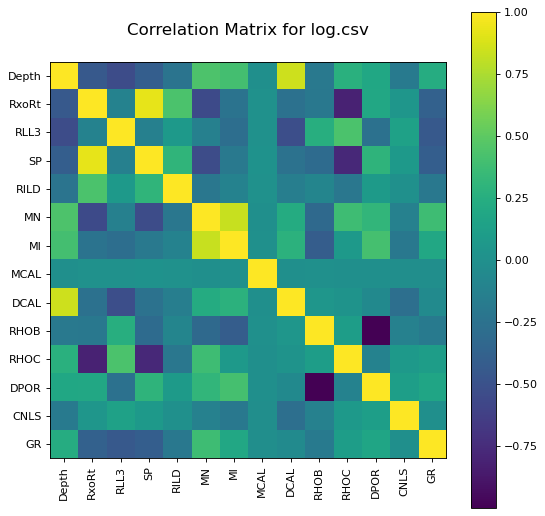

In [9]:
plotCorrelationMatrix(df1, 8)

****As we can see above, if I am building a model for SP, then we can see that SP is highly correlated with RxoRt and it is highly neagatively related with RHOC. So, it is very must for us to include these datasets as an input while building a model for SP. ****

> **Before making a model decide a threshold of correlation to decide which parameters to take as an input for making models**.

We can also make a scatter plot to visualize the same data

Scatter and density plots:

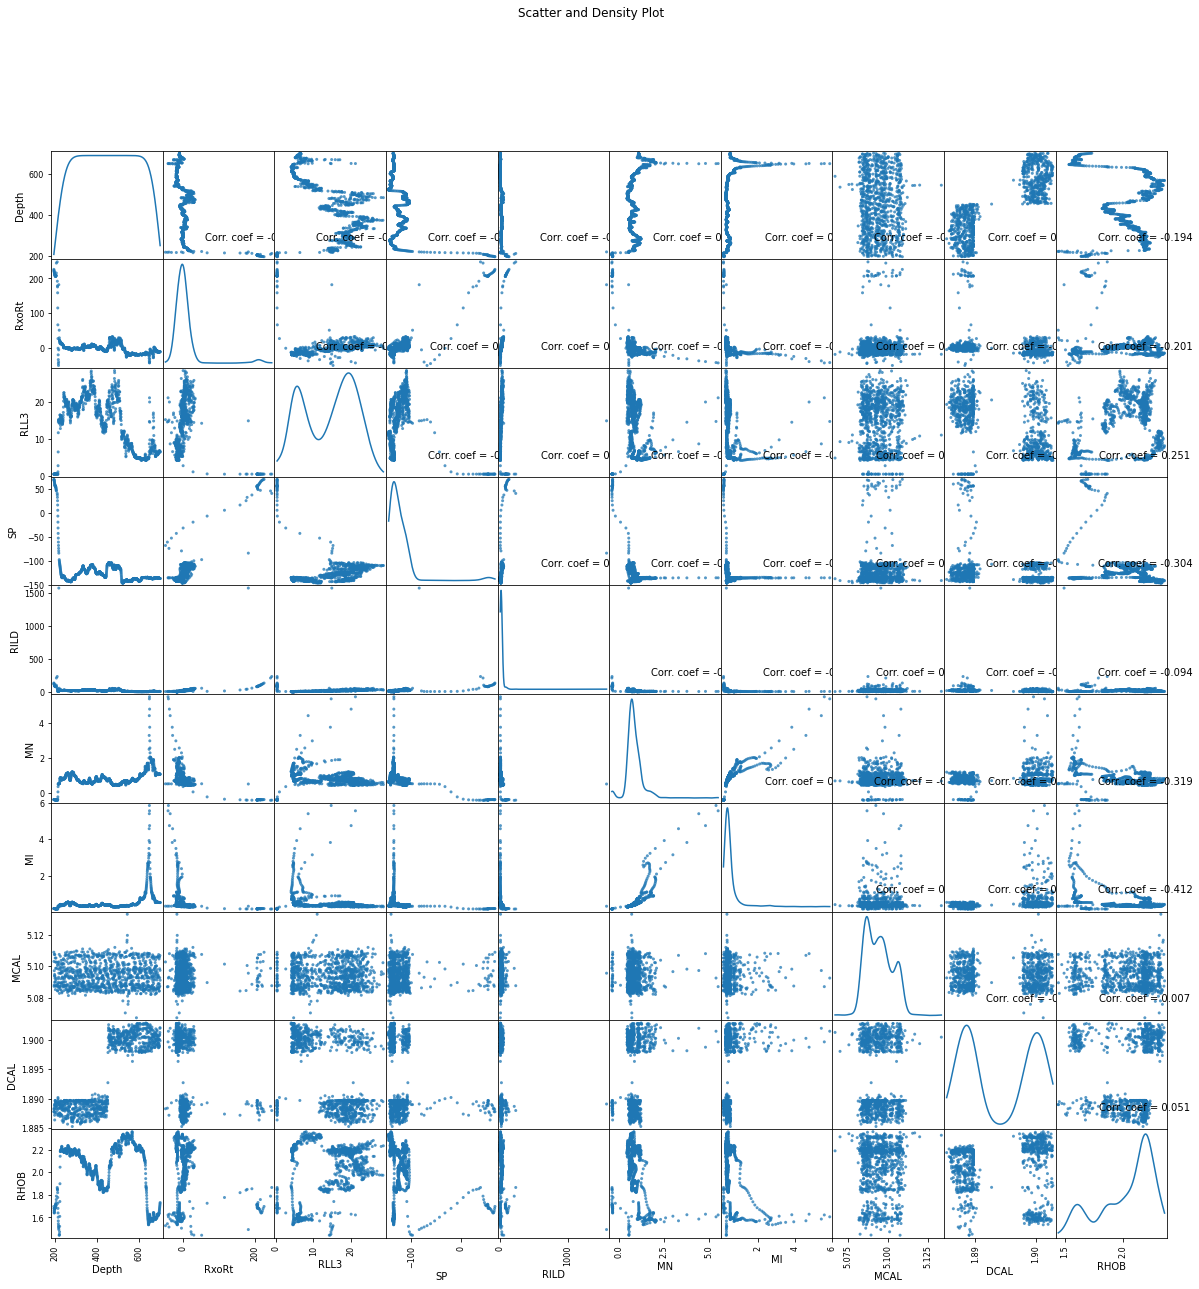

In [10]:
plotScatterMatrix(df1, 20, 10)

## Import Deep learning Dependencies and libray Pytorch

In [11]:
!conda install pytorch torchvision cudatoolkit=10.2 -c pytorch

Solving environment: - ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



In [249]:
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, TensorDataset


Now we are going to build our own model class WellLogModel, which is build over nn.modules of PyTorch. I will tell you later, What this code do. But first run the below code. We will come back here to see what it will do.

In [250]:
class WellLogModel(nn.Module):
    """Model to create Neural Network"""
    def __init__(self, in_dim,H,out_dim):
        super(WellLogModel, self).__init__()
        self.input_layer= nn.Linear(in_dim,H//2)
        self.hidden_1 = nn.Linear(H//2,H)
        self.hidden_2 = nn.Linear(H,H//2)
        self.output_layer = nn.Linear(H//2,out_dim)
    def forward(self, x):
        h_relu = self.input_layer(x)
        h_relu = F.relu(h_relu) # First activation
        h_relu = self.hidden_1(h_relu)
        h_relu = F.relu(h_relu) # Second activation
        h_relu = self.hidden_2(h_relu)
        h_relu = F.relu(h_relu) # Third activation
        y_pred = self.output_layer(h_relu)
        return y_pred
        
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  # Generate predictions
        loss = F.l1_loss(out, targets)        # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                    # Generate predictions
        loss = F.l1_loss(out, targets)          # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [251]:
# evaluation and fitting code, This will evaluate our model performance and cost function
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

## change SGD to change the optimizer
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    val_hist = []
    train_hist = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_hist.append(loss.item())
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        val_hist.append(result)
    return val_hist,train_hist

## Import data and convert into tensors

In [252]:
DATA_FILENAME = "/kaggle/input/log.csv"
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

,Depth,RxoRt,RLL3,SP,RILD,MN,MI,MCAL,DCAL,RHOB,RHOC,DPOR,CNLS,GR
0,195.0,226.0848,0.4076,69.8953,132.5052,-0.3548,0.1863,5.1090,1.8878,1.6973,-0.6303,59.2216,30.0657,60.4576
1,195.5,223.5031,0.4063,69.2303,123.6225,-0.3619,0.1867,5.1031,1.8882,1.6791,-0.6409,60.2877,26.7625,54.1495
2,196.0,221.4560,0.4047,68.4478,116.9258,-0.3668,0.1860,5.0872,1.8878,1.6585,-0.6539,61.4914,27.6017,51.9944
3,196.5,219.8248,0.4033,67.4843,111.7925,-0.3613,0.1867,5.0881,1.8884,1.6435,-0.6649,62.3711,31.5870,52.9645
4,197.0,218.1438,0.4023,66.3013,106.7821,-0.3569,0.1870,5.0972,1.8883,1.6390,-0.6705,62.6343,35.8251,54.9659


In [253]:
# Get Number of Rows and Number of Colums
num_rows, num_cols = dataframe.shape
print("Number of Rows : ",num_rows)
print("Number of Colums : ",num_cols)

Number of Rows :  8739
Number of Colums :  14


## Decide Input data and output data

I am going to train a model for Density porosity DPOR, so my output will be DPOR. To know what should be the Input we have to see the Correlation plot to see how DPOR is related to other parameter.

But actually there is no need to do it here, because our neural network is so big that it will automatically discards all the parameters which has no relation with RHOB. But it always adviced to choose best correlated data to make algorithm faster and give less load to the algorithm. Deep learning algorithms are computationaly very expensive specialy for big datas.

In [254]:
# I am using all the parameter as input except DPOR, which is ouput
output_cols = [dataframe.DPOR.name]             # modify DPOR.name to your model.
print(f'Output feature are : {output_cols}')
input_cols = [cols for cols in dataframe]
input_cols.remove(output_cols[0])               # input data = all data - output data.
print(f'Input layers are {input_cols}')



Output feature are : ['DPOR']
Input layers are ['Depth', 'RxoRt', 'RLL3', 'SP', 'RILD', 'MN', 'MI', 'MCAL', 'DCAL', 'RHOB', 'RHOC', 'CNLS', 'GR']


### Convert dataframe into input and output array

I am using input_cols and output_cols to extract data from dataframe and then convert them to numpy. To do this I am making a function called dataframe2array()

In [255]:
def dataframe2arrays(dataframe):
    # Extract and convert required data to array
    dataframe1 = dataframe.copy(deep=True)
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [256]:
# call dataframe2array to extract data in input_array and target_array
inputs_array, targets_array = dataframe2arrays(dataframe)
inputs_array, targets_array

# convert array into tensors using torch.tensor()
inputs = torch.tensor(inputs_array, dtype=torch.float32)
targets = torch.tensor(targets_array, dtype=torch.float32)

In [257]:
# print some values
print(f'Input {inputs[0:2]},\n output {targets[0:2]}')

Input tensor([[ 1.9500e+02,  2.2608e+02,  4.0760e-01,  6.9895e+01,  1.3251e+02,
         -3.5480e-01,  1.8630e-01,  5.1090e+00,  1.8878e+00,  1.6973e+00,
         -6.3030e-01,  3.0066e+01,  6.0458e+01],
        [ 1.9550e+02,  2.2350e+02,  4.0630e-01,  6.9230e+01,  1.2362e+02,
         -3.6190e-01,  1.8670e-01,  5.1031e+00,  1.8882e+00,  1.6791e+00,
         -6.4090e-01,  2.6763e+01,  5.4150e+01]]),
 output tensor([[59.2216],
        [60.2877]])


## Divide Dataset into Train, Validation and Test Data.

Now to go further we have to divide our data set into 3 parts
1. Training dataset : It is the data which we use to train the model. Generally 60-70% of data go for training.
2. Validation dataset : This data is used to test the performance of our model and to visualize the error and cost function of model. It is also used to see how our algorithm performs by changing our hyperparameters(i.e Learning rate, momentum etc.)
3. Test dataset : This is the final testing dataset to use for testing purpose. The difference between testing data and validation data is, we do not take any decision on the basis of tesitng data performance. If our algorithm does not perform well on the testing data then, either there is something wrong with the model preparation or something wrong with hyperparameters and optimization choosing.

As a common practice 15% is devoted to validation and 15% data is devoted to testing. I have done the same.

In [258]:
# First combine our input and targets into one dataset
dataset = TensorDataset(inputs, targets)
# print some dataset
print(f'Dataset {dataset[0:2]}')

Dataset (tensor([[ 1.9500e+02,  2.2608e+02,  4.0760e-01,  6.9895e+01,  1.3251e+02,
         -3.5480e-01,  1.8630e-01,  5.1090e+00,  1.8878e+00,  1.6973e+00,
         -6.3030e-01,  3.0066e+01,  6.0458e+01],
        [ 1.9550e+02,  2.2350e+02,  4.0630e-01,  6.9230e+01,  1.2362e+02,
         -3.6190e-01,  1.8670e-01,  5.1031e+00,  1.8882e+00,  1.6791e+00,
         -6.4090e-01,  2.6763e+01,  5.4150e+01]]), tensor([[59.2216],
        [60.2877]]))


The dataset is a collection of inputs and targets zip together into a one set. we do this, to easily divide both data together, other wise it is long code to divide then individually and other problems such as indexing.

#### Define the percentage of data we want to extract.

In [259]:
## training and validation spliting
def split_ds(dataset, val_percent):
    val_size = int(len(dataset) * val_percent)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length
    return train_ds, val_ds

In [260]:
val_percent = 0.30 # between 0.2 and 0.3
train_ds, val_ds = split_ds(dataset, val_percent)
print(f'Train dataset {train_ds[0:3]}\n')
print(f'Validation dataset{val_ds[0:3]}')

Train dataset (tensor([[ 4.3230e+03, -2.0521e+00,  1.9216e+02, -1.1633e+02,  2.0713e+02,
          1.5942e+02,  1.6811e+02,  7.9637e+00,  7.7627e+00,  2.6905e+00,
          1.8200e-02,  2.5927e+00,  4.2111e+01],
        [ 2.9635e+03, -2.2523e+01,  1.6554e+01, -5.3847e+01,  9.1812e+00,
          1.0518e+00,  2.5280e-01,  5.0897e+00,  2.0210e+00,  1.6930e+00,
          1.3380e-01,  9.1260e+00,  5.6320e+01],
        [ 1.6585e+03, -8.5337e+01,  5.8981e+00, -1.5570e+02,  3.6750e+00,
          3.4758e+00,  3.4651e+00,  5.0930e+00,  1.9196e+00,  1.4215e+00,
          2.7100e-02,  1.1616e+01,  5.1755e+01]]), tensor([[ 1.1376],
        [59.4716],
        [75.3505]]))

Validation dataset(tensor([[ 2.9370e+03, -3.2024e+01,  7.7704e+00, -6.1047e+01,  3.5307e+00,
          3.0210e-01,  7.8900e-02,  5.1076e+00,  1.9773e+00,  1.7430e+00,
          1.5170e-01,  1.8539e+01,  6.5221e+01],
        [ 4.4950e+03, -1.7971e+01,  7.7800e+01, -8.8573e+01,  4.8683e+01,
          5.2799e+01,  6.0395e+01,  7.9828

The validation data contain 30% of data, now I extract 15% for training data and 15% for val_ds

In [261]:
test_percent = 0.5
test_ds, val_ds = split_ds(val_ds, test_percent)
print(f'Train dataset size is {len(train_ds)}\n')
print(f'Test dataset size is {len(test_ds)}\n')
print(f'Validation dataset size is {len(val_ds)}')

Train dataset size is 6118

Test dataset size is 1311

Validation dataset size is 1310


#### Make the batches of dataset, dataloader and GPU config
Here my dataset is not that big but in general the datasets are very big in 10-100 millions. In that case we need to run the algorithm in the batches. I divide dataset into dataloader with 64 element in each batch.

I also configure my dataloader for GPU's. If GPU is available then our algorithm will work on CUDA.

I also shuffle the train loader to make algorithm more random and powerfull.

In [262]:
batch_size = 64
# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

In [263]:
# To print loaders we have to use for loop
for X,Y in train_loader:
    print(f'Input of train loader {X}')
    print(f'Targets of train loader {X}')
    break # it only print one element

Input of train loader tensor([[ 3.7095e+03, -1.5628e+01,  1.4406e+01, -3.8928e+01,  1.0923e+01,
          9.4168e+00,  1.6517e+01,  8.0497e+00,  8.0254e+00,  2.5966e+00,
          4.2600e-02,  1.9946e+01,  9.2314e+01],
        [ 1.1205e+03,  1.4955e+01,  1.1535e+01, -1.2200e+02,  1.5675e+01,
          3.9370e-01,  1.8050e-01,  5.0955e+00,  1.8975e+00,  1.9157e+00,
          2.2580e-01,  3.8856e+01,  7.2840e+01],
        [ 3.5730e+03, -1.6704e+01,  5.9436e+00, -4.2643e+01,  3.9063e+00,
          5.1490e-01,  1.6410e-01,  5.0991e+00,  8.9010e+00,  2.4097e+00,
          1.4650e-01,  3.1357e+01,  1.3123e+02],
        [ 3.4020e+03, -2.0689e+01,  1.7308e+01, -3.9713e+01,  9.9077e+00,
          1.2287e+00,  2.9530e-01,  5.0982e+00,  2.0446e+00,  2.0604e+00,
          2.8680e-01,  6.3007e+00,  4.3837e+01],
        [ 1.6475e+03, -2.3133e+01,  8.1271e+00, -1.3822e+02,  3.7086e+00,
          1.7258e+00,  1.3562e+00,  5.0841e+00,  1.9190e+00,  1.4346e+00,
          3.4800e-02,  4.2579e+01,  6.3431

# Build the network

This is how our neural network look like
* It has 13 input features with one bias(not shown here)
* It has 18 neurons in first hidden layer
* 36 neurons in 2nd hidden layer
* 18 neurons in 3rd hidden layer
* and 1 output layer (here RHOB)
![](https://i.imgur.com/EyoxGX2.png)

In [264]:
in_dim, H, out_dim = len(input_cols), 36 , len(output_cols) # see the WellLogModel class for reference

In [265]:
# call the WellLogModel in model variable
model = WellLogModel(in_dim,H,out_dim)

In [266]:
# see the model
model

WellLogModel(
  (input_layer): Linear(in_features=13, out_features=18, bias=True)
  (hidden_1): Linear(in_features=18, out_features=36, bias=True)
  (hidden_2): Linear(in_features=36, out_features=18, bias=True)
  (output_layer): Linear(in_features=18, out_features=1, bias=True)
)

## Set the GPU device

we set our device to fastest hardware, if gpu is available we switch our algorithm to GPU otherwise it will work on CPU.

In [267]:
# see wheather GPU is availabel or not
torch.cuda.is_available()

True

In [268]:
# This will pick the gpu details if you have (Don't go in details, just run and use it)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [269]:
device = get_default_device()
device

device(type='cuda')

In [270]:
# move our data and model to device GPU or CPU whichever is availabel
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

Now we have to create new dataloader for device, because the previous dataloader will only work on CPU's.

In [271]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [272]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)


In [273]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([[23.6992],
        [53.8483],
        [15.1834],
        [ 9.4153],
        [55.9741],
        [49.8511],
        [55.6100],
        [29.5685],
        [62.5438],
        [27.8088],
        [27.8128],
        [13.4314],
        [ 6.9251],
        [74.4966],
        [41.0792],
        [85.8226],
        [ 5.0954],
        [10.7903],
        [42.0002],
        [58.3532],
        [73.1666],
        [50.2112],
        [72.7853],
        [69.1467],
        [88.4891],
        [64.0314],
        [52.6521],
        [30.1660],
        [42.9240],
        [36.3901],
        [36.3033],
        [ 2.7276],
        [40.0057],
        [53.3297],
        [ 2.8930],
        [57.5651],
        [74.7233],
        [62.9930],
        [82.4945],
        [77.4242],
        [ 5.3925],
        [49.2495],
        [45.6287],
        [37.6810],
        [64.3983],
        [29.1728],
        [39.9308],
        [20.3713],
        [29.0208],
        [55.6067],
        [28.4879],
        [

In [274]:
model = WellLogModel(in_dim,H,out_dim)
to_device(model, device)

WellLogModel(
  (input_layer): Linear(in_features=13, out_features=18, bias=True)
  (hidden_1): Linear(in_features=18, out_features=36, bias=True)
  (hidden_2): Linear(in_features=36, out_features=18, bias=True)
  (output_layer): Linear(in_features=18, out_features=1, bias=True)
)

In [275]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Check loss for random weights

In [276]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 47.53800582885742}]

* ## Train model on loop and epoches

In [277]:
history += fit(300, 0.005, model, train_loader, val_loader)

Exception in thread Thread-3999:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/opt/conda/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/conda/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/opt/conda/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process()

KeyboardInterrupt: 

## Visualize the loss.

In [191]:
hist = []
for i in history:
    hist.append(i['val_loss'])

In [192]:
hist = np.array(hist)

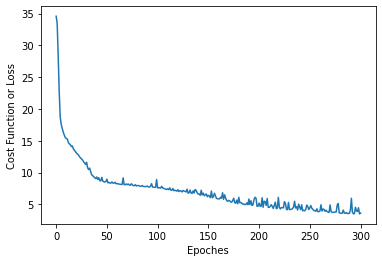

In [193]:
plt.figure("Validation Loss History")
plt.xlabel("Epoches")
plt.ylabel("Cost Function or Loss")
plt.plot(hist)

## Visualize our predicted values and original values

In [195]:
for xb,yb in val_loader:
    X = xb
    Y = yb
    break

In [197]:
pred_val = model(X)

In [198]:
pred_val, orig_val = X_a.detach().cpu().numpy(),Y.detach().cpu().numpy()

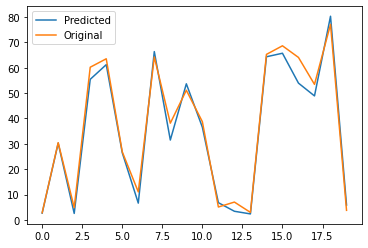

In [200]:
plt.figure("Predicted Vs Original Values Plot")
plt.plot(pred_val[0:20], label='Predicted')
plt.plot(orig_val[0:20], label='Original')
plt.legend()

In [219]:
print(f'Predicted values are {pred_val[0:10]}\n original Log Values are {orig_val[0:10]}')

Predicted values are [[ 2.65337  ]
 [30.27817  ]
 [ 2.5359268]
 [55.452778 ]
 [61.241554 ]
 [26.485723 ]
 [ 6.6008224]
 [66.39538  ]
 [31.494596 ]
 [53.68617  ]]
 original Log Values are [[ 2.8084]
 [30.4453]
 [ 4.8355]
 [60.2299]
 [63.5593]
 [26.8471]
 [11.0184]
 [64.2852]
 [38.1547]
 [51.1356]]


#### As we can see we have predicted the values of data as close as 2 units which is very good in terms of well log, because in well log we only want approximate values. +- of 2 unit is acceptable.

#### but anybody can make it more accurate by adjusting the neural network parameters. Here the +- 2 unit of error can be due to very wide neural network. sometimes small neural network works well then more neurons.

try to give the neural network to the lower in my case gives me low loss and high accuracy. You can chage the codes and try yourself.